## Library Imports

In [89]:
import os
import sys
import time
import argparse
import json



import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd


from herbie_vision.model.centernet import get_hourglass, exkp

from herbie_vision.utils.image import annotations_to_df, process_resizing
from herbie_vision.utils.gcp_utils import download_blob, upload_blob


from google.api_core.protobuf_helpers import get_messages
from google.cloud import storage

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/peterfagan/Desktop/gcp/waymo-2d-object-detection-514eeefdb0a3.json"

In [122]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model



# Initialize model and device
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = get_model_instance_segmentation(4)
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=4)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=4,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)




model=model.to(device)
model.load_state_dict(torch.load('/Users/peterfagan/Downloads/weights_1.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [123]:
def plot_outputs(img, bbox, scores):    
    # Create figure and axes
    fig, ax = plt.subplots(figsize = (200,20))
    
    # Display the image
    ax.imshow(img)
    i=0
    scores_ind = [idx for idx,x in enumerate(scores) if x>0.4]
    for idx, entry in enumerate(bbox):
        if idx in scores_ind:
          h = entry[2]-entry[0]
          w = entry[3]-entry[1]
          # Create a Rectangle patch
          rect = patches.Rectangle((entry[0],entry[1]), h, w, linewidth=2, edgecolor='r', facecolor='none')
          
          # Add classification category
          # plt.text(entry[0], entry[1], s=str(labels[idx]), 
          #         color='white', verticalalignment='top',
          #         bbox={'color': 'red', 'pad': 0})

        # Add the patch to the Axes
        ax.add_patch(rect)
        i+=1

    plt.show()

[{'boxes': tensor([[3.2558e+00, 4.0056e+02, 9.6195e+01, 6.3110e+02],
        [9.6494e+02, 3.5791e+02, 1.0719e+03, 6.2787e+02],
        [8.0466e+02, 3.7300e+02, 9.3593e+02, 6.5887e+02],
        [1.8466e+02, 3.5738e+02, 3.4022e+02, 4.5985e+02],
        [1.0063e+03, 3.8576e+02, 1.0696e+03, 6.0912e+02],
        [3.4580e+02, 3.7729e+02, 5.4498e+02, 4.6064e+02],
        [5.8802e+02, 3.7181e+02, 7.4556e+02, 4.3502e+02],
        [1.6064e+02, 3.6115e+02, 2.1502e+02, 5.0778e+02],
        [6.2301e+01, 3.2208e+02, 3.6894e+02, 4.6122e+02],
        [1.0285e+03, 4.1623e+02, 1.0638e+03, 6.1662e+02],
        [9.2005e+02, 3.9430e+02, 1.1130e+03, 6.0508e+02],
        [7.3727e+02, 3.6399e+02, 8.1942e+02, 4.2784e+02],
        [8.6213e+02, 3.5638e+02, 9.4946e+02, 6.5262e+02],
        [2.2116e+02, 3.8273e+02, 3.2159e+02, 4.5796e+02],
        [9.7345e+02, 3.8337e+02, 1.0114e+03, 5.8603e+02],
        [8.1165e+02, 4.7432e+02, 8.7783e+02, 6.5637e+02],
        [8.3694e+02, 4.5654e+02, 9.0477e+02, 6.6872e+02],
   

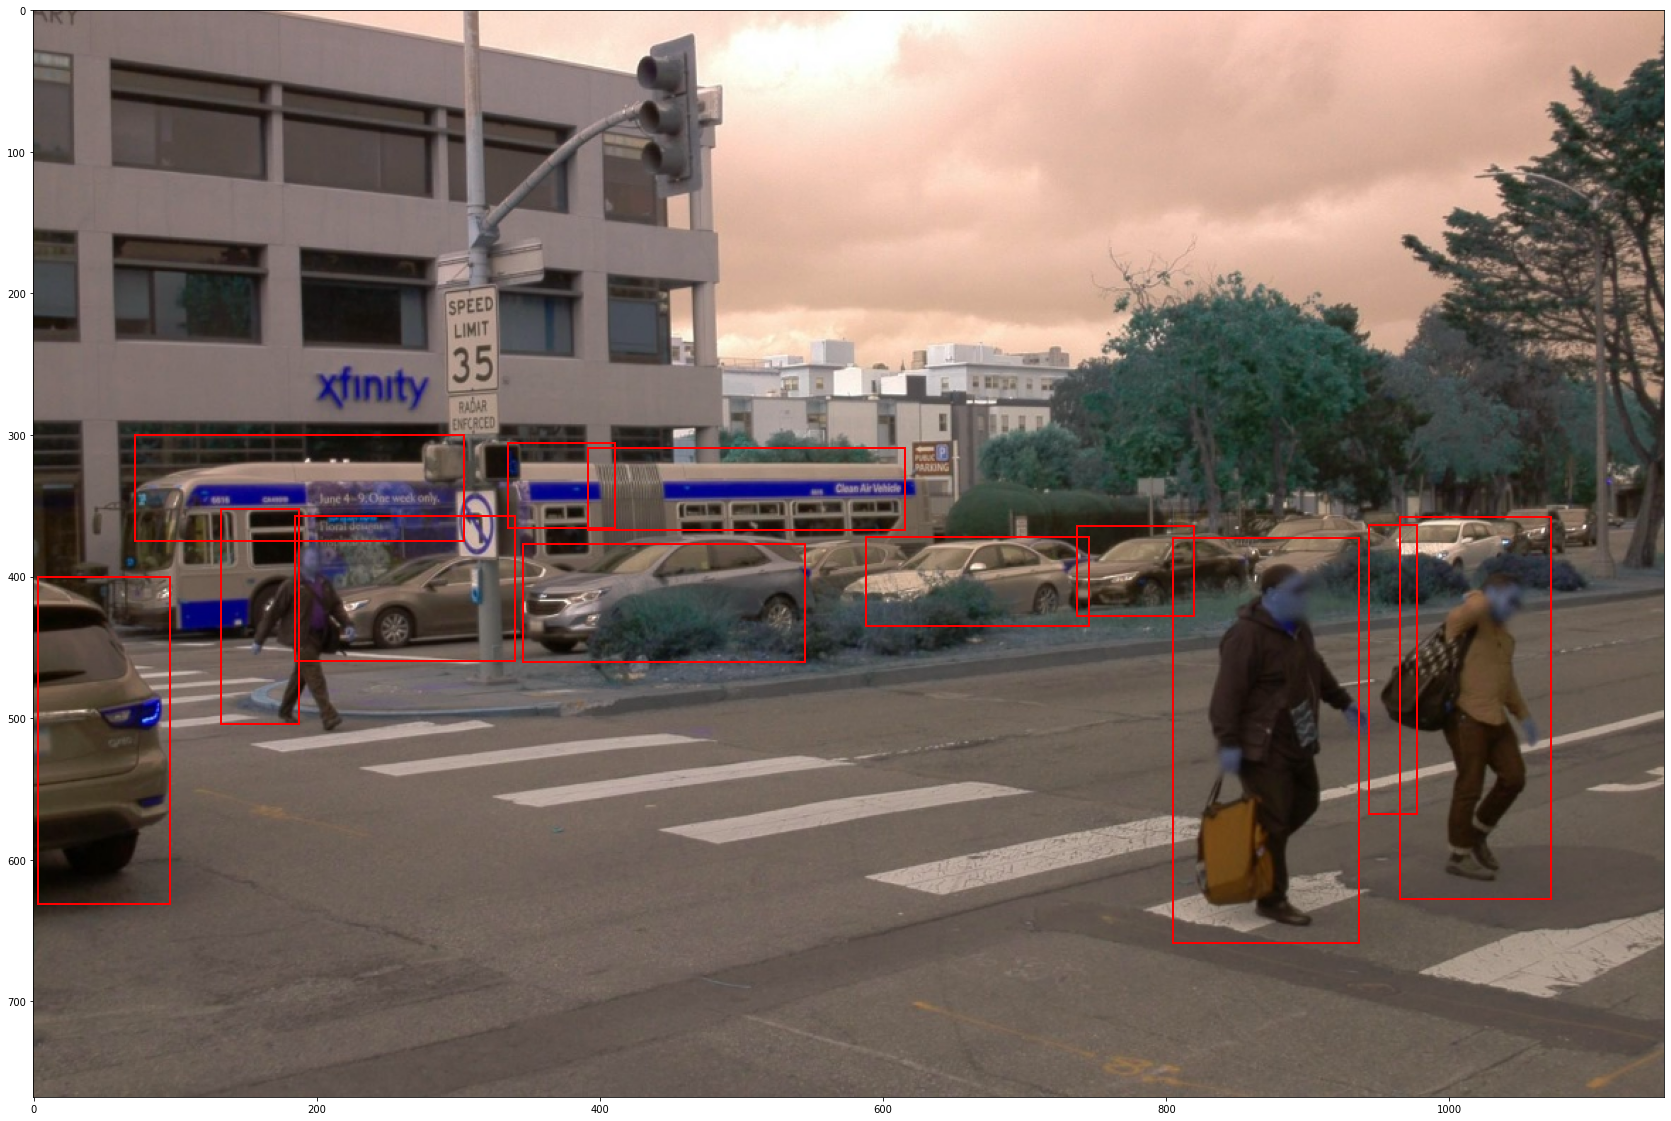

In [126]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

img = cv2.imread('/Users/peterfagan/Desktop/test.jpeg')
img = torch.tensor(img).permute(2,0,1).float().to(device)

img = [img]
import numpy as np
model.eval()
outputs = model(img)

def plot_outputs(img, bbox, scores):    
    # Create figure and axes
    fig, ax = plt.subplots(figsize = (200,20))
    
    # Display the image
    ax.imshow(img)
    i=0
    scores_ind = [idx for idx,x in enumerate(scores) if x>0.1]
    for idx, entry in enumerate(bbox):
        if idx in scores_ind:
            h = entry[2]-entry[0]
            w = entry[3]-entry[1]
            # Create a Rectangle patch
            rect = patches.Rectangle((entry[0],entry[1]), h, w, linewidth=2, edgecolor='r', facecolor='none')
          
          # Add classification category
          # plt.text(entry[0], entry[1], s=str(labels[idx]), 
          #         color='white', verticalalignment='top',
          #         bbox={'color': 'red', 'pad': 0})

        # Add the patch to the Axes
        ax.add_patch(rect)
        i+=1

    plt.show()

# img = img.squeeze(0).to('cpu').permute(1,2,0).numpy()
img = cv2.imread('/Users/peterfagan/Desktop/test.jpeg')
bbox = outputs[0]['boxes']
scores = outputs[0]['scores']
labels = outputs[0]['labels']

keep = torchvision.ops.nms(bbox,scores,0.1)
labels = [int(x.detach().to('cpu')) for idx, x in enumerate(labels) if idx in keep]
bbox = [x.detach().to('cpu') for idx, x in enumerate(bbox) if idx in keep]

print(outputs)
plot_outputs(np.array(img), bbox, scores)

## Data Import

In [ ]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    
    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    )
    
    

client = storage.Client()
bucket = client.get_bucket('waymo-processed')

download_blob('waymo-processed',
              'train/images/2019-02-13/10017090168044687777_6380_000_6400_000/10017090168044687777_6380_000_6400_000_150_FRONT.jpeg',
              '/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/example_1.jpeg')
download_blob('waymo-processed',
              'train/annotations/2019-02-13/10017090168044687777_6380_000_6400_000.json',
              '/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/annotations.json')

## Examine Annotations

In [ ]:
# Read in image annotations
f = open('/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/annotations.json','r')
annotations = json.load(f)
f.close()

## Plot Bounding Boxes

In [ ]:
img = cv2.imread('/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/example_1.jpeg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
anns = [x for x in annotations['annotations'] if x['image_id']=='10017090168044687777_6380_000_6400_000_150_FRONT']

# Create figure and axes
fig, ax = plt.subplots(figsize = (200,20))

# Display the image
ax.imshow(rgb_img)

for entry in anns:
    h = entry['bbox'][3]
    w = entry['bbox'][2]
    x = entry['bbox'][0]
    y = entry['bbox'][1]
    
    # Create a Rectangle patch
    rect = patches.Rectangle((x,y), h, w, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()


# Import dataset locally

In [2]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    )

In [7]:
CATEGORY_NAMES = ['TYPE_VEHICLE','TYPE_PEDESTRIAN','TYPE_CYCLIST']
CATEGORY_IDS = [1,2,4]

class WaymoDataset(data.Dataset):
    def __init__(self, gcp_bucket, gcp_annotations_path, local_path_to_images, 
                 local_path_to_processed_images, cat_names, cat_ids):
        super(WaymoDataset, self).__init__()
        
        # filepaths
        self.gcp_bucket = gcp_bucket
        self.gcp_annotations_path = gcp_annotations_path
        self.local_path_to_images = local_path_to_images
        self.local_path_to_processed_images = local_path_to_processed_images
        
        # high level summary values
        self.num_classes = len(cat_names)
        self.category_names = cat_names
        self.category_ids = cat_ids
        
        
        # setup data directory
        if os.path.exists('./data')==False:
            os.mkdir('./data')
            os.mkdir(self.local_path_to_images)
            os.mkdir(self.local_path_to_processed_images)
        
        
        # read in annotations
        client = storage.Client()
        bucket = client.get_bucket(self.gcp_bucket)
        
        download_blob(self.gcp_bucket,
                           self.gcp_annotations_path,
                           './data/annotations.json')
        
        f = open('./data/annotations.json','r')
        self.annotations = json.load(f)
        f.close()
        
        # convert annotations to dataframe
        self.annotations_df = annotations_to_df(self.annotations, self.local_path_to_images)

        
        # determine segment paths
        self.segment_paths = []
        for image in self.annotations['images']:
            uri = image['gcp_url']
            segment = '/'.join(uri.split('/')[3:7])+'/'
            if segment not in self.segment_paths:
                self.segment_paths.append(segment)
        
        
        # Download images for segments to local folder
        for segment in self.segment_paths:
            blobs = bucket.list_blobs(prefix=segment, delimiter='/')
            for blob in list(blobs):
                filename=blob.name.replace(segment,'')
                blob.download_to_filename('./data/images/{}'.format(filename))


        # Drop images without annotations
        self.annotations['images'] = [x for x in self.annotations['images'] if x['id'] in self.annotations_df['image_id'].unique()]
        
        # Preprocess images to be the same size
        self.annotations_df = process_resizing(self.local_path_to_processed_images, self.annotations_df,800)
        
            
            
    def __getitem__(self, idx):
        image_id = self.annotations['images'][idx]['id']
        image_url = self.annotations['images'][idx]['gcp_url']
        filename = image_url.split('/')[-1]
        image = Image.open(self.local_path_to_processed_images+'{}'.format(filename))
        image = np.asarray(image, dtype="float64") / 255.
        image = torch.tensor(image).permute(2,0,1).float()        
        
        # define target data for fast rcnn
        temp_df = self.annotations_df[self.annotations_df['image_id']==image_id]

        boxes = []
        labels = []
        areas = []
        for _,item in temp_df.iterrows():
            boxes.append([item['xr_min'],item['yr_min'],item['xr_max'],item['yr_max']])
            labels.append(item['category_id'])
            areas.append(item['area'])
        
        boxes = torch.tensor(boxes)
        areas = torch.tensor(areas)
        labels = torch.tensor(labels)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = torch.zeros((temp_df.shape[0],), dtype=torch.int64)
        
        return image, target
    
    def __len__(self):
        return len(self.annotations['images'])

In [8]:
dataset = WaymoDataset('waymo-processed','train/annotations/2019-05-22/11940460932056521663_1760_000_1780_000.json','./data/images/','./data/images_processed/', CATEGORY_NAMES, CATEGORY_IDS)
train_dataloader = data.DataLoader(dataset, batch_size=8)

Blob train/annotations/2019-05-22/11940460932056521663_1760_000_1780_000.json downloaded to ./data/annotations.json.


# Resizing images and bounding boxes

In [ ]:
def annotations_to_df(annotations):
    df = pd.DataFrame(annotations['annotations'])
    df['filename'] = df['image_id'].apply(lambda x :os.getcwd()+'/data/images/{}.jpeg'.format(x))
    df['x_min'] = df['bbox'].apply(lambda x: x[0])
    df['y_min'] = df['bbox'].apply(lambda x: x[1])
    df['width'] = df['bbox'].apply(lambda x: x[2])
    df['height'] = df['bbox'].apply(lambda x: x[3])
    df['x_max'] = df['x_min'] + df['height']
    df['y_max'] = df['y_min'] + df['width']
    df.drop(columns='bbox',inplace=True)

    return df

def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)
    Y[bb[1]:bb[3], bb[0]:bb[2]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([top_row, left_col, bottom_row, right_col], dtype=np.float32)


def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = np.array(Image.open(read_path))
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = write_path + read_path.split('/')[-1]
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)


def process_resizing(resized_path, annotations_df, sz):
    new_paths = []
    new_bbs = []
    for index, row in annotations_df[['filename','x_min','y_min','x_max','y_max']].iterrows():
        new_path,new_bb = resize_image_bb(row['filename'], resized_path,
                                          np.array(row[['x_min','y_min','x_max','y_max']]),sz)
        new_paths.append(new_path)
        new_bbs.append(new_bb)
    annotations_df['processed_filepath'] = new_paths
    annotations_df['resized_bb'] = new_bbs
    annotations_df['xr_min'] = annotations_df['resized_bb'].apply(lambda x: x[0])
    annotations_df['yr_min'] = annotations_df['resized_bb'].apply(lambda x: x[1])
    annotations_df['xr_max'] = annotations_df['resized_bb'].apply(lambda x: x[2])
    annotations_df['yr_max'] = annotations_df['resized_bb'].apply(lambda x: x[3])
    annotations_df.drop(columns='resized_bb',inplace=True)
    
    
    return annotations_df    

In [ ]:
annotations_df = annotations_to_df(dataset.annotations)
process_resizing('./data/images_processed/',annotations_df, 800)

In [ ]:
# resized_img = cv2.resize(orig_img,(800,800))
# bb = np.array([example['x_min'][0],example['y_min'][0],
#               example['x_max'][0],example['y_max'][0]])
# mask = create_mask(bb,orig_img)
# resized_mask = cv2.resize(mask,(800,800))
# resized_bb = mask_to_bb(resized_mask)

# rect = patches.Rectangle((bb[0],bb[1]), h, w, linewidth=2, edgecolor='r', facecolor='none')


# # Create figure and axes
# fig, ax = plt.subplots(figsize = (200,20))

# # Display the image
# ax.imshow(resized_img)

# # Create a Rectangle patch
# rect = patches.Rectangle((resized_bb[1],resized_bb[0]), resized_bb[2]-resized_bb[0], resized_bb[3]-resized_bb[1], linewidth=2, edgecolor='r', facecolor='none')

# # Add the patch to the Axes
# ax.add_patch(rect)

# plt.show()

In [ ]:
annotations_df = annotations_to_df(dataset.annotations)
example = annotations_df[annotations_df['image_id']=='10017090168044687777_6380_000_6400_000_150_FRONT'].reset_index()
orig_img = np.array(Image.open(example['filename'].unique()[0]))

def plot_w_annotations(img, annotations_df, resized=False):    
    # Create figure and axes
    fig, ax = plt.subplots(figsize = (200,20))
    
    # Display the image
    ax.imshow(img)

    for entry in annotations_df.iterrows():
        if resized==False:
            h = entry[1]['height']
            w = entry[1]['width']
            x = entry[1]['x_min']
            y = entry[1]['y_min']
        else:
            h = entry[1]['xr_max']-entry[1]['xr_min']
            w = entry[1]['yr_max']-entry[1]['yr_min']
            x = entry[1]['xr_min']
            y = entry[1]['yr_min']

        # Create a Rectangle patch
        rect = patches.Rectangle((x,y), h, w, linewidth=2, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()
    
plot_w_annotations(orig_img, example)

In [ ]:
updated_df = process_resizing('./data/images_processed/', example, 800)

In [ ]:
resized_img = np.array(Image.open(example['processed_filepath'].unique()[0]))
plot_w_annotations(resized_img, updated_df, resized=True)

In [ ]:
inputs = torch.tensor(resized_img).permute(2,0,1).unsqueeze(0)/255.
outputs = model(inputs)
len(outputs[0]['boxes'])

In [ ]:
resized_img = cv2.resize(orig_img,(800,800))
bb = np.array([example['x_min'][0],example['y_min'][0],
              example['x_max'][0],example['y_max'][0]])
mask = create_mask(bb,orig_img)
resized_mask = cv2.resize(mask,(800,800))
resized_bb = mask_to_bb(resized_mask)

# Refining Data Loader

In [ ]:
import torch 

import os
from herbie_vision.utils.image import annotations_to_df, process_resizing
from herbie_vision.utils.gcp_utils import download_blob, upload_blob

CATEGORY_NAMES = ['TYPE_VEHICLE','TYPE_PEDESTRIAN','TYPE_CYCLIST']
CATEGORY_IDS = [1,2,4]

class WaymoDataset(data.Dataset):
    def __init__(self, gcp_bucket, gcp_annotations_path, local_path_to_images, 
                 local_path_to_processed_images, cat_names, cat_ids):
        super(WaymoDataset, self).__init__()
        
        # filepaths
        self.gcp_bucket = gcp_bucket
        self.gcp_annotations_path = gcp_annotations_path
        self.local_path_to_images = local_path_to_images
        self.local_path_to_processed_images = local_path_to_processed_images
        
        # high level summary values
        self.num_classes = len(cat_names)
        self.category_names = cat_names
        self.category_ids = cat_ids
        
        
        # setup data directory
        if os.path.exists('./data')==False:
            os.mkdir('./data')
            os.mkdir(self.path_to_images)
            os.mkdir(self.path_to_processed_images)
        
        
        # read in annotations
        client = storage.Client()
        bucket = client.get_bucket(self.gcp_bucket)
        
        download_blob(self.gcp_bucket,
                           self.gcp_annotations_path,
                           './data/annotations.json')
        
        f = open('./data/annotations.json','r')
        self.annotations = json.load(f)
        f.close()
        
        # convert annotations to dataframe
        self.annotations_df = annotations_to_df(self.annotations)

        
        # determine segment paths
#         self.segment_paths = []
#         for image in self.annotations['images']:
#             uri = image['gcp_url']
#             segment = '/'.join(uri.split('/')[3:7])+'/'
#             if segment not in self.segment_paths:
#                 self.segment_paths.append(segment)
        
        
        # Download images for segments to local folder
#         for segment in self.segment_paths:
#             blobs = bucket.list_blobs(prefix=segment, delimiter='/')
#             for blob in list(blobs):
#                 filename=blob.name.replace(segment,'')
#                 blob.download_to_filename('./data/images/{}'.format(filename))


#         # Drop images without annotations
        self.annotations['images'] = [x for x in self.annotations['images'] if x['id'] in self.annotations_df['image_id'].unique()]
        
#         # Preprocess images to be the same size
#         self.annotations_df = process_resizing(self.local_path_to_processed_images, self.annotations_df,800)
        
#         self.annotations_df.to_csv('./data/annotations.csv')

        self.annotations_df = pd.read_csv('./data/annotations.csv')
            
            
    def __getitem__(self, idx):
        image_id = self.annotations['images'][idx]['id']
        image_url = self.annotations['images'][idx]['gcp_url']
        filename = image_url.split('/')[-1]
        image = Image.open(self.local_path_to_processed_images+'{}'.format(filename))
        image = np.asarray(image, dtype="float64") / 255.
        image = torch.tensor(image).permute(2,0,1).float()        
        
        # define target data for fast rcnn
        temp_df = self.annotations_df[self.annotations_df['image_id']==image_id]

        boxes = []
        labels = []
        areas = []
        for _,item in temp_df.iterrows():
            boxes.append([item['xr_min'],item['yr_min'],item['xr_max'],item['yr_max']])
            labels.append(item['category_id'])
            areas.append(item['area'])
        
        boxes = torch.tensor(boxes)
        areas = torch.tensor(areas)
        labels = torch.tensor(labels)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = torch.zeros((temp_df.shape[0],), dtype=torch.int64)
        
        return image, target
    
    def __len__(self):
        return len(self.annotations['images'])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = WaymoDataset('waymo-processed','train/annotations/2019-02-13/10017090168044687777_6380_000_6400_000.json','./data/images/','./data/images_processed/', CATEGORY_NAMES, CATEGORY_IDS)
test = data.Subset(dataset, indices=[1,2])
train_dataloader = data.DataLoader(test, batch_size=4, 
                                   shuffle=True, collate_fn=collate_fn)

## Model Playground

### Faster rcnn

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Initialize model and set to eval mode
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# 2 classes; Only target class or background
num_classes = 3
num_epochs = 25
model = get_model_instance_segmentation(num_classes)

# move model to the right device
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(train_dataloader)



In [ ]:
# tens = torch.randn(3,800,800).unsqueeze(0)
model.eval()
model(tens)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in train_dataloader:
        i += 1
        imgs = list(img for img in imgs)
        annotations = [{k: v for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')


    

In [ ]:
model.eval()
for img, _ in train_dataloader:
    outputs = model(img)
    img = np.array(img[0].permute(1,2,0))
    plt.imshow(img)
    print(outputs[1])

In [ ]:
for entry in outputs[0]['boxes']:
    print(entry.detach().numpy())
    break

In [ ]:
for entry in outputs[0]['boxes'][0]:
    print(entry)

In [ ]:
def plot_outputs(img, bbox):    
    # Create figure and axes
    fig, ax = plt.subplots(figsize = (200,20))
    
    # Display the image
    ax.imshow(img)
    i=0
    for entry in bbox:
        
        entry=entry.detach().numpy()
        h = entry[2]-entry[0]
        w = entry[3]-entry[1]
        # Create a Rectangle patch
        rect = patches.Rectangle((entry[0],entry[1]), h, w, linewidth=2, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        i+=1
        if i==10:
            break

    plt.show()
    
plot_outputs(img, outputs[0]['boxes'])

In [ ]:
model.eval()

### Centernet

In [ ]:
# instantiate model
model = exkp(n=5, nstack=2, dims=[256, 256, 384, 384, 384, 512], modules=[2, 2, 2, 2, 2, 4],num_classes=3)
model.train()

    
inputs = torch.randn(1,3,512,512)
outputs = model(inputs)
hmap_tl, hmap_br, hmap_ct, embd_tl, embd_br, regs_tl, regs_br, regs_ct = zip(*outputs)